In [2]:
import pickle as pkl
import glob

In [224]:
!cp /Users/gilles/Science/7t_binocular/pilot/behavior/raw/GdH_1_2017-08-18_11.00.32_outputDict.pkl \
    /Users/gilles/Science/7t_binocular/pilot/behavior/clean/070/run1.pkl 
    
!cp /Users/gilles/Science/7t_binocular/pilot/behavior/raw/GdH_1_2017-08-18_11.08.40_outputDict.pkl \
    /Users/gilles/Science/7t_binocular/pilot/behavior/clean/055/run1.pkl     
    
!cp /Users/gilles/Science/7t_binocular/pilot/behavior/raw/GdH_1_2017-08-18_11.16.11_outputDict.pkl \
    /Users/gilles/Science/7t_binocular/pilot/behavior/clean/070/run2.pkl 

!cp /Users/gilles/Science/7t_binocular/pilot/behavior/raw/GdH_1_2017-08-18_11.22.48_outputDict.pkl \
    /Users/gilles/Science/7t_binocular/pilot/behavior/clean/055/run2.pkl 
    
!cp /Users/gilles/Science/7t_binocular/pilot/behavior/raw/GdH_1_2017-08-18_11.29.18_outputDict.pkl \
    /Users/gilles/Science/7t_binocular/pilot/behavior/clean/070/run3.pkl 
    
!cp /Users/gilles/Science/7t_binocular/pilot/behavior/raw/GdH_1_2017-08-18_11.35.52_outputDict.pkl \
    /Users/gilles/Science/7t_binocular/pilot/behavior/clean/055/run3.pkl     
    
!cp /Users/gilles/Science/7t_binocular/pilot/behavior/raw/GdH_1_2017-08-18_11.42.44_outputDict.pkl \
    /Users/gilles/Science/7t_binocular/pilot/behavior/clean/070/run4.pkl         
    
!cp /Users/gilles/Science/7t_binocular/pilot/behavior/raw/GdH_1_2017-08-18_11.49.05_outputDict.pkl \
    /Users/gilles/Science/7t_binocular/pilot/behavior/clean/055/run4.pkl         
    
!cp /Users/gilles/Science/7t_binocular/pilot/behavior/raw/GdH_1_2017-08-18_11.55.42_outputDict.pkl \
    /Users/gilles/Science/7t_binocular/pilot/behavior/clean/070/run5.pkl         
    
!cp /Users/gilles/Science/7t_binocular/pilot/behavior/raw/GdH_1_2017-08-18_12.02.20_outputDict.pkl \
    /Users/gilles/Science/7t_binocular/pilot/behavior/clean/055/run5.pkl         
    


In [225]:
import pandas

In [226]:
import re

In [378]:
def get_data(data, parameters=False):
    
    eventArray = data['eventArray']
    parameterArray = data['parameterArray']
    
    all_events = [str(e) for t in eventArray for e in t]
                
    reg = re.compile('(?P<string>trial (?P<trial>[0-9a-z]+)(( phase (?P<phase>[0-9]+))|( event (?P<event>[a-z0-9]+)))?( started)? at (?P<t>[0-9]+\.[0-9]+))')

    
    df = pandas.DataFrame([reg.match(e).groupdict() if reg.match(e) else {'string':e} for e in all_events ])
    
    df['t'] = df['t'].astype(float)
    
    
    if parameters:
        start_trigger = df[df.event == 't'].t.min()        
        df = df[df.phase == '2']
        df['onset'] = df['t'] - start_trigger

        parameters = pandas.DataFrame(data['parameterArray'])

        df = pandas.concat((df.reset_index(), parameters.iloc[1: df.shape[0]+1].reset_index()), 1)
        df['draw_dots'] = df['draw_dots'].astype(bool)

    return pandas.DataFrame(df)
        

In [379]:
df = get_data(data, parameters=True)

In [380]:
from nistats import design_matrix

In [381]:
# 0.55: 50 
# 0.70: 75

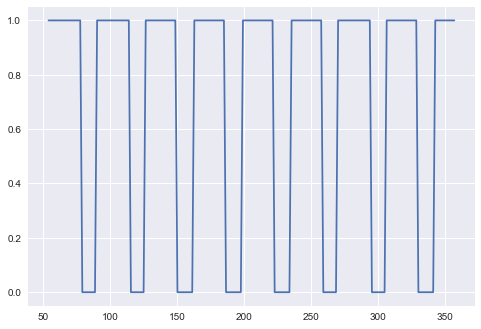

In [388]:
plt.plot(df.t, df.draw_dots)

/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/utils.py:182: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


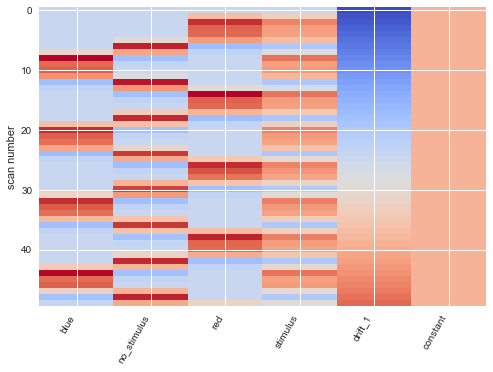

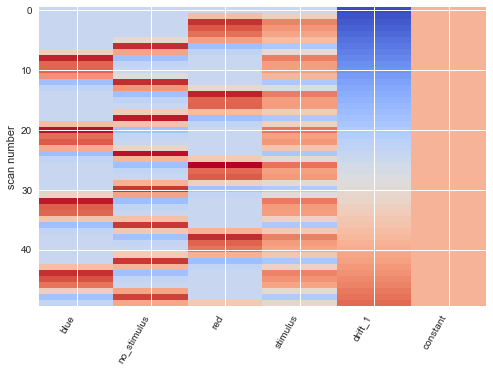

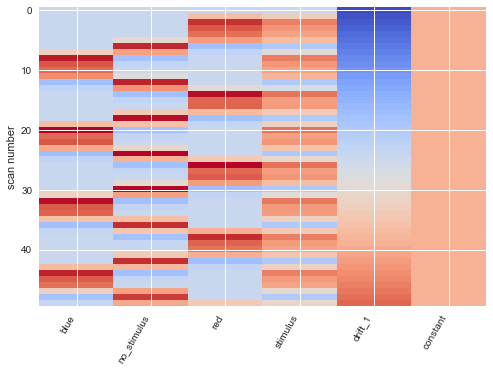

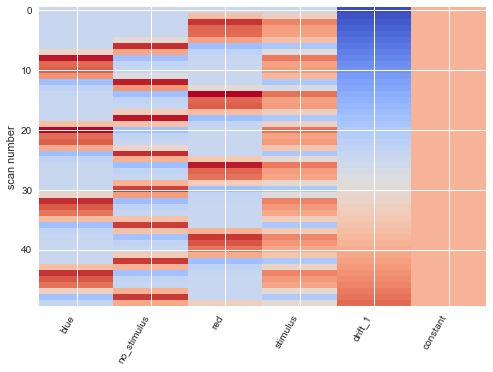

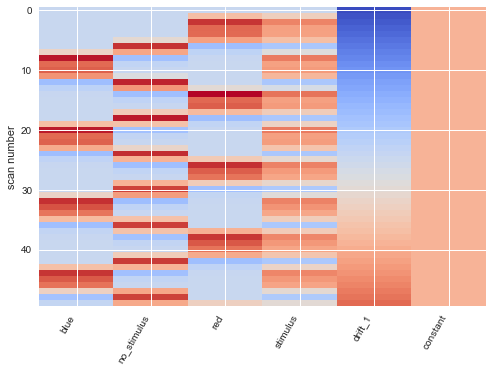

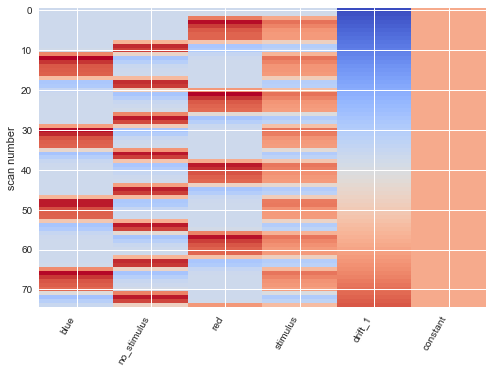

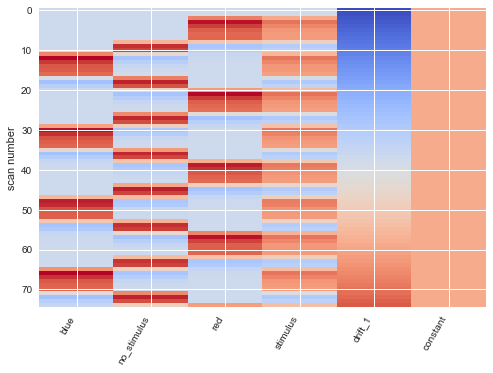

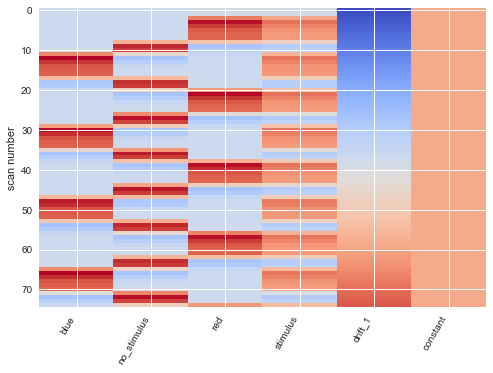

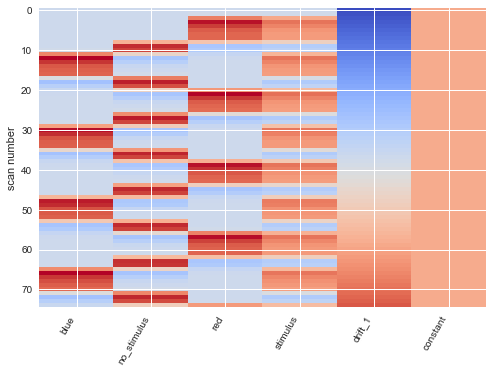

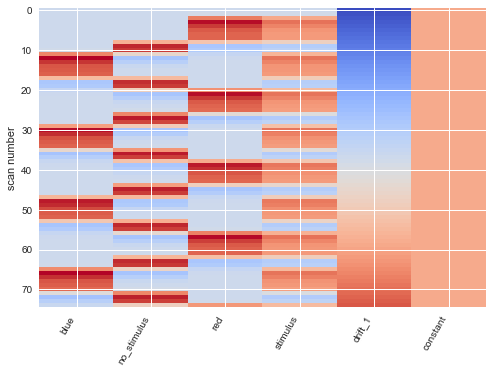

In [395]:
reg = re.compile('.*/(?P<protocol>[0-9]+)/run(?P<run>[0-9]+)\.pkl')

df = []

for fn in glob.glob('/Users/gilles/Science/7t_binocular/pilot/behavior/clean/*/*.pkl'):
    data = pkl.load(open(fn, 'rb'), encoding='latin1')
    df = get_data(data, parameters=True)
    resolution = reg.match(fn).group(1)
    run = int(reg.match(fn).group(2))
    
    conditions = ['stimulus', 'no_stimulus', 'red', 'blue']

    onsets = [df[df.draw_dots].onset.tolist(),
              df[~df.draw_dots].onset.tolist(),
              df[(df.color == 'r') & df.draw_dots].onset.tolist(),
              df[(df.color == 'b') & df.draw_dots].onset.tolist()]
    
    tr = {'055':6.5, '070':4.0}[resolution]
    n_scans = {'055':50, '070':75}[resolution]
    
    frame_times = np.arange(n_scans) * tr
    
    paradigm = []

    for condition, onset in zip(conditions, onsets):
        paradigm.append(pandas.DataFrame({'trial_type':condition, 'onset':onset}))

    paradigm = pandas.concat(paradigm)

    hrf_model = 'glover'

    X1 = make_design_matrix(frame_times, paradigm, drift_model='polynomial', drift_order=1,hrf_model=hrf_model)
    
#     np.savetxt('design_matrix_resolution-%s_run-%s.txt' % (resolution, run), X1)

    X1.to_csv('design_matrix_resolution-%s_run-%s.tsv' % (resolution, run), sep='\t')
    
    plt.figure()
    plot_design_matrix(X1)
    plt.set_cmap("coolwarm")

In [396]:
import nistats

In [397]:
from nistats.first_level_model import FirstLevelModel


In [401]:
from nilearn.input_data import NiftiMasker

In [ ]:
masker.fit()

In [402]:
masker = NiftiMasker()
masker.fit('/Users/gilles/data/hires/055/sub-012/av/sub-012_EPI055_run-1_bold_volreg_sg_psc_av.nii.gz')

NiftiMasker(detrend=False, high_pass=None, low_pass=None, mask_args=None,
      mask_img=None, mask_strategy='background',
      memory=Memory(cachedir=None), memory_level=1, sample_mask=None,
      sessions=None, smoothing_fwhm=None, standardize=False, t_r=None,
      target_affine=None, target_shape=None, verbose=0)

In [418]:
tr = 6.5

In [419]:
t_r = tr

In [420]:
first_level_model = FirstLevelModel(t_r, hrf_model='glover + derivative', mask=masker.mask_img_)

In [421]:
data = '/Users/gilles/data/hires/055/sub-012/av/sub-012_EPI055_run-1_bold_volreg_sg_psc_av.nii.gz'

In [426]:
design_matrix = pandas.read_csv('design_matrix_resolution-055_run-1.tsv', sep='\t')

In [423]:
first_level_model.fit(data, design_matrices=design_matrix[['red', 'blue']])

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
        hrf_model='glover + derivative',
        mask=<nibabel.nifti1.Nifti1Image object at 0x120230ef0>,
        memory=Memory(cachedir=None), memory_level=1, min_onset=-24,
        minimize_memory=True, n_jobs=1, noise_model='ar1', period_cut=128,
        signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=None,
        standardize=False, subject_label=None, t_r=6.5, target_affine=None,
        target_shape=None, verbose=0)

In [424]:
zmap = first_level_model.compute_contrast('red - blue')
zmap.to_filename('z_map_red_blue.nii.gz')

In [425]:
zmap = first_level_model.compute_contrast('red + blue')
zmap.to_filename('z_map.nii.gz')

In [353]:
from nistats.design_matrix import make_design_matrix, plot_design_matrix


In [357]:
tr = 6.0
n_scans = 350 / 6


/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/utils.py:182: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


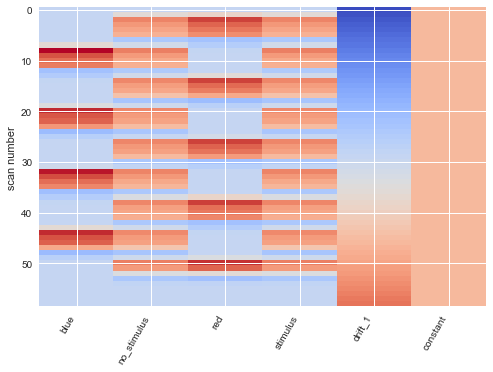

In [373]:
plot_design_matrix(X1)
plt.set_cmap('coolwarm')

In [432]:
data = sorted(glob.glob('/Users/gilles/data/hires/055/sub-012/psc/sub-012_EPI055_run-*_bold_volreg_sg_psc.nii.gz'))
design_matrices = [pandas.read_csv(fn, sep='\t')[['red', 'blue']] for fn in sorted(glob.glob('design_matrix_resolution-055_run-*.tsv'))]

In [434]:
first_level_model.fit(data, design_matrices=design_matrices)

/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/first_level_model.py:61: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'
/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/first_level_model.py:65: RuntimeWarning: overflow encountered in multiply
  Y = 100 * (Y / mean - 1)
/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/regression.py:204: RuntimeWarning: invalid value encountered in subtract
  wresid = wY - np.dot(self.wdesign, beta)
/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/regression.py:291: RuntimeWarning: invalid value encountered in subtract
  return self.Y - self.predicted
/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/regression.py:263: RuntimeWarning: invalid value encountered in subtract
  _X[(i + 1)

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
        hrf_model='glover + derivative',
        mask=<nibabel.nifti1.Nifti1Image object at 0x120230ef0>,
        memory=Memory(cachedir=None), memory_level=1, min_onset=-24,
        minimize_memory=True, n_jobs=1, noise_model='ar1', period_cut=128,
        signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=None,
        standardize=False, subject_label=None, t_r=6.5, target_affine=None,
        target_shape=None, verbose=0)

In [435]:
zmap = first_level_model.compute_contrast('red + blue')
zmap.to_filename('z_map_stimulation_no-stimulation_fe.nii.gz')

/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/first_level_model.py:545: UserWarning: One contrast given, assuming it for all 5 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/utils.py:206: RuntimeWarning: invalid value encountered in less_equal
  return np.where(X <= 0, 0, 1. / X)
/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/contrasts.py:255: RuntimeWarning: invalid value encountered in add
  effect_ = self.effect + other.effect
/Users/gilles/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/gilles/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/gilles/ana

In [436]:
zmap = first_level_model.compute_contrast('red - blue')
zmap.to_filename('z_map_red_blue_fe.nii.gz')

/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/first_level_model.py:545: UserWarning: One contrast given, assuming it for all 5 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/Users/gilles/anaconda3/lib/python3.6/site-packages/nistats-0.1.0-py3.6.egg/nistats/utils.py:206: RuntimeWarning: invalid value encountered in less_equal
  return np.where(X <= 0, 0, 1. / X)
/Users/gilles/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/gilles/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/gilles/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/gilles/anaconda3/

(0, 100)

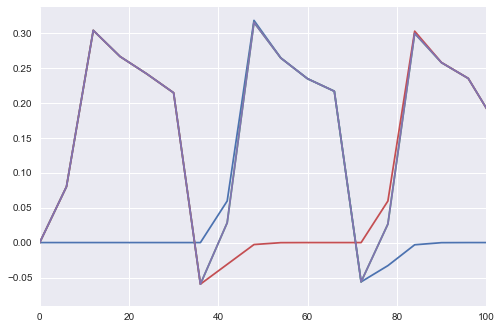

In [374]:
plt.plot(X1.iloc[:, :4])
plt.xlim(0, 100)

In [260]:
reg = re.compile('.*/(?P<protocol>[0-9]+)/run(?P<run>[0-9]+)\.pkl')

df = []

for fn in glob.glob('/Users/gilles/Science/7t_binocular/pilot/behavior/clean/*/*.pkl'):
    data = pkl.load(open(fn, 'rb'), encoding='latin1')
    tmp = get_phases(data)
    tmp['resolution'] = reg.match(fn).group(1)
    tmp['run'] = int(reg.match(fn).group(2))
    
    df.append(tmp)
df = pandas.concat(df)

In [261]:
import seaborn as sns

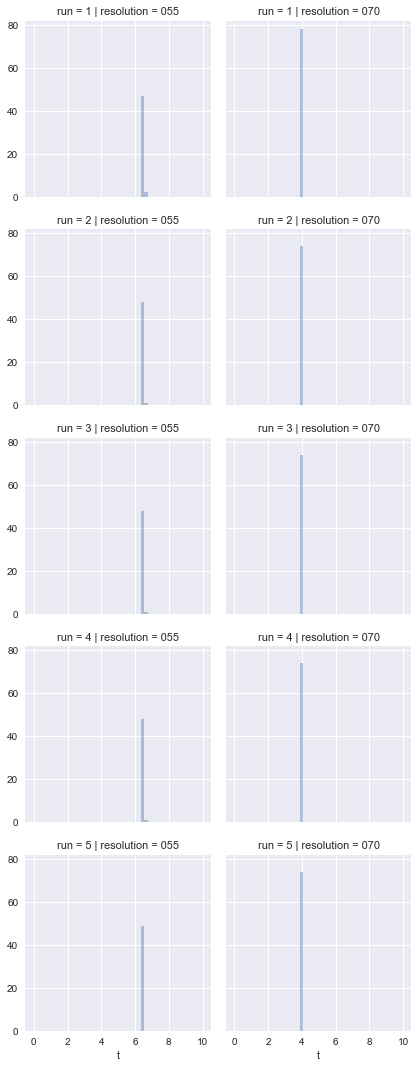

In [262]:
tmp = df[df.event == 't'].groupby(['resolution', 'run']).t.apply(lambda x: pandas.Series(x.values[1:] - x.values[:-1], index=x.index[:-1]))

fac = sns.FacetGrid(tmp.reset_index(), row='run', col='resolution')
fac.map(sns.distplot, 't', bins=np.linspace(0, 10, 50), kde=False)

In [276]:
def get_trial_onsets(d):
    
    start_trigger = d[d.event == 't'].t.min()
    
    d = d[d.phase == '2']
    d['onset'] = d['t'] - start_trigger
    
    return d

In [277]:
d = df[(df.resolution == '055') & (df.run == 1)]
get_trial_onsets(d)

/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,event,phase,string,t,trial,resolution,run,onset
3,None,2,trial 0 phase 2 started at 51.2555088997,51.255509,0,055,1,1.594369
7,None,2,trial 1 phase 2 started at 52.8471000195,52.847100,1,055,1,3.185960
10,None,2,trial 2 phase 2 started at 54.4306118488,54.430612,2,055,1,4.769472
12,None,2,trial 3 phase 2 started at 56.0223238468,56.022324,3,055,1,6.361184
16,None,2,trial 4 phase 2 started at 57.6141409874,57.614141,4,055,1,7.953001
20,None,2,trial 5 phase 2 started at 59.1891388893,59.189139,5,055,1,9.527999
22,None,2,trial 6 phase 2 started at 60.772521019,60.772521,6,055,1,11.111381
25,None,2,trial 7 phase 2 started at 62.3475298882,62.347530,7,055,1,12.686390
29,None,2,trial 8 phase 2 started at 63.9226720333,63.922672,8,055,1,14.261532
32,None,2,trial 9 phase 2 started at 65.4977190495,65.497719,9,055,1,15.836579


In [220]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  2.,   0.,   2.,   0.,  35.,  31.,   0.,   2.,   0.,   2.]),
 array([-4.06497192, -4.05200584, -4.03903976, -4.02607367, -4.01310759,
        -4.0001415 , -3.98717542, -3.97420933, -3.96124325, -3.94827716,
        -3.93531108]),
 <a list of 10 Patch objects>)

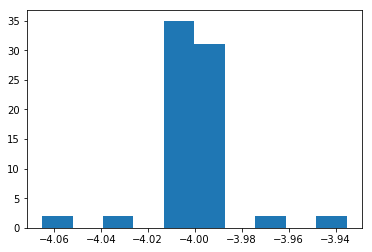

In [221]:
plt.hist(df[df.event == 't'].t.values[:-1] - df[df.event == 't'].t.values[1:])

In [250]:
data['parameterArray']

[{},
 {'barframe_seed': 1986,
  'block_length': 24.0,
  'blue_intensity': 1.0,
  'coherence': 0.5,
  'color': 'r',
  'correct': True,
  'direction': 0,
  'dot_life': 3,
  'dotsize_deg': 0.1,
  'draw_dots': True,
  'fieldsize_deg': 9,
  'fixation_time': 0.5,
  'height_barsquare': 11,
  'left_key': 'b',
  'n_dots': 300,
  'red_intensity': 0.75,
  'rest_length': 12.0,
  'right_key': 'y',
  'simulate_mri_trigger': False,
  'size_fixation_deg': 0.25,
  'speed': 0.2,
  'square_size_deg': 0.5,
  'stimulus_time': 1.0,
  'thickness_bars': 3,
  'tr': 4.0,
  'width_barsquare': 11},
 {'barframe_seed': 1986,
  'block_length': 24.0,
  'blue_intensity': 1.0,
  'coherence': 0.5,
  'color': 'r',
  'correct': True,
  'direction': 0,
  'dot_life': 3,
  'dotsize_deg': 0.1,
  'draw_dots': True,
  'fieldsize_deg': 9,
  'fixation_time': 0.5,
  'height_barsquare': 11,
  'left_key': 'b',
  'n_dots': 300,
  'red_intensity': 0.75,
  'rest_length': 12.0,
  'right_key': 'y',
  'simulate_mri_trigger': False,
  'siz

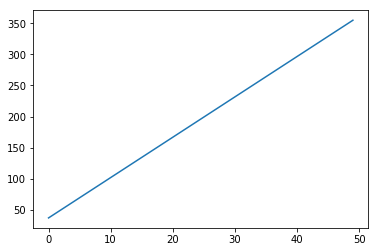

In [201]:
plt.plot(df[df.event == 't'].t.values)

In [162]:
reg.match(get_phases(eventArray)[2]).groupdict()

TypeError: list indices must be integers or slices, not str

In [50]:
reg = re.compile('trial (?P<trial>[0-9]+) phase (?P<phase>[0-9]+) started at (?P<t>[0-9]\.[0-9]+)')

eventArray = data['eventArray']
all_events = [str(e) for t in eventArray for e in t]

for t in all_events:
    
    if reg.match(t):
        reg.match(t).groupdict()

In [47]:
t

[-99, 0.28807616233825684]

In [ ]:
all_events

In [43]:
t

['trial wait started at 0.706175088882', 'trial wait event t at 37.2424180508']

In [37]:
get_phases(trials)

['trial wait started at 0.706175088882', 'trial wait event t at 37.2424180508', 'trial 0 phase 1 started at 37.8366370201', 'trial 0 event y at 38.7649550438', 'trial 0 phase 2 started at 38.8367509842', 'trial 1 phase 1 started at 39.4298501015', 'trial 1 phase 2 started at 40.4284620285', 'trial 2 event y at 40.5648591518', 'trial 2 phase 1 started at 41.0117869377', 'trial 2 phase 2 started at 42.0118131638', 'trial 3 event y at 42.10374403', 'trial 3 phase 1 started at 42.6034879684', 'trial 3 event y at 43.5398819447', 'trial 3 phase 2 started at 43.6035420895', 'trial 4 event t at 43.7122449875', 'trial 4 phase 1 started at 44.1954009533', 'trial 4 event y at 44.9373061657', 'trial 4 phase 2 started at 45.1952731609', 'trial 5 phase 1 started at 45.7703740597', 'trial 5 event b at 46.6373980045', 'trial 5 phase 2 started at 46.7704091072', 'trial 6 phase 1 started at 47.3537249565', 'trial 6 event b at 48.1152031422', 'trial 6 phase 2 started at 48.3538510799', 'trial 7 phase 1 s

TypeError: expected string or bytes-like object

In [21]:
trials = data['eventArray']

In [23]:
import numpy as np

['trial wait started at 0.706175088882',
 'trial wait event t at 37.2424180508',
 'trial 0 phase 1 started at 37.8366370201',
 'trial 0 event y at 38.7649550438',
 'trial 0 phase 2 started at 38.8367509842',
 'trial 1 phase 1 started at 39.4298501015',
 'trial 1 phase 2 started at 40.4284620285',
 'trial 2 event y at 40.5648591518',
 'trial 2 phase 1 started at 41.0117869377',
 'trial 2 phase 2 started at 42.0118131638',
 'trial 3 event y at 42.10374403',
 'trial 3 phase 1 started at 42.6034879684',
 'trial 3 event y at 43.5398819447',
 'trial 3 phase 2 started at 43.6035420895',
 'trial 4 event t at 43.7122449875',
 'trial 4 phase 1 started at 44.1954009533',
 'trial 4 event y at 44.9373061657',
 'trial 4 phase 2 started at 45.1952731609',
 'trial 5 phase 1 started at 45.7703740597',
 'trial 5 event b at 46.6373980045',
 'trial 5 phase 2 started at 46.7704091072',
 'trial 6 phase 1 started at 47.3537249565',
 'trial 6 event b at 48.1152031422',
 'trial 6 phase 2 started at 48.35385107

In [20]:
data

{'eventArray': [['trial wait started at 0.706175088882',
   'trial wait event t at 37.2424180508'],
  ['trial 0 phase 1 started at 37.8366370201',
   'trial 0 event y at 38.7649550438',
   'trial 0 phase 2 started at 38.8367509842'],
  ['trial 1 phase 1 started at 39.4298501015',
   'trial 1 phase 2 started at 40.4284620285'],
  ['trial 2 event y at 40.5648591518',
   'trial 2 phase 1 started at 41.0117869377',
   'trial 2 phase 2 started at 42.0118131638'],
  ['trial 3 event y at 42.10374403',
   'trial 3 phase 1 started at 42.6034879684',
   'trial 3 event y at 43.5398819447',
   'trial 3 phase 2 started at 43.6035420895'],
  ['trial 4 event t at 43.7122449875',
   'trial 4 phase 1 started at 44.1954009533',
   'trial 4 event y at 44.9373061657',
   'trial 4 phase 2 started at 45.1952731609'],
  ['trial 5 phase 1 started at 45.7703740597',
   'trial 5 event b at 46.6373980045',
   'trial 5 phase 2 started at 46.7704091072'],
  ['trial 6 phase 1 started at 47.3537249565',
   'trial 6 

In [336]:
[i * 2 * (24 + 12) for i in range(6)]

[0, 72, 144, 216, 288, 360]

In [337]:
[24 + 12 + i * 2 * (24 + 12) for i in range(6)]

[36, 108, 180, 252, 324, 396]

In [338]:
[24 + i * (24 + 12) for i in range(10)]

[24, 60, 96, 132, 168, 204, 240, 276, 312, 348]

# 0.55

In [326]:
[i * 2 * (26 + 13) for i in range(6)]

[0, 78, 156, 234, 312, 390]

In [328]:
[26 + 13 + i * 2 * (26 + 13) for i in range(6)]

[39, 117, 195, 273, 351, 429]

In [334]:
[26 + i * (26 + 13) for i in range(10)]

[26, 65, 104, 143, 182, 221, 260, 299, 338, 377]

# no stimulus

[24, 60, 96, 132, 168, 204, 240, 276, 312, 348]

[26, 65, 104, 143, 182, 221, 260, 299, 338, 377]